# Prétraiter les données de WaPOR en utilisant Python

Ce notebook contient les étapes pour prétraiter les données de WaPOR

-	[1. Ouvrir et enregistrer les données raster](#1.-Ouvrir-et-enregistrer-les-données-raster)
-	[2. Agréger les données selon une période](#2.-Agréger-les-données-selon-une-période)
-	[3. Transformer des données raster](#3.-Transformer-des-données-raster)
-	[4. Découper suivant la ligne de coupe d’un shapefile](#4.-Découper-suivant-la-ligne-de-coupe-d’un-shapefile)

Pour chaque étape, vous trouverez un exemple de codes et des exercices pour appliquer cet exemple.

Premièrement importer les librairies/packages de sorte que les fonctions de ces librairies puissent être utilisées.

In [1]:
import os
import sys
import shapefile
import glob
import gdal
import osgeo
import osr
import ogr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
folder=r"..\..\modules"
sys.path.append(folder) # ajouter un dossier avec des modules locaux aux chemins du système
import WaPOR # importer les modules locaux de 'WaPOR'

## 1. Ouvrir et enregistrer les données raster
### Exemple
Afin de travailler avec des données raster en Python, nous devrons d´abord ouvrir et lire ces données raster en tant que tableau numérique et effectuer des calculs avec ce tableau. Le package * gdal * contient des fonctions pour travailler avec des cartes raster qui peuvent être utilisées pour effectuer cette tâche. Vous trouverez ci-dessous les étapes pour obtenir ces informations à partir d'un fichier GeoTIFF. Dans cet exemple, nous utiliserons les ensembles de données raster d'évapotranspiration réelles mensuelles et d'interception (AETI) de niveau 1 téléchargés lors de l'exercice précédent [notebook](1_Bulk_download_WaPOR_data.ipynb). 

Tout d'abord, pour lire un fichier raster, nous aurons besoin du chemin d'accès à ce fichier. Dans la cellule de code ci-dessous, le code récupère la liste des fichiers raster (au format GeoTIFF) dans un dossier d'entrée, puis imprime le chemin d´accès du premier fichier.

In [2]:
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M' #definir le dossier des entrés input_folder
input_fhs=sorted(glob.glob(input_folder+'\*.tif')) #obtenir la liste des fichiers tif dans le input_folder

in_fh=input_fhs[0] #obtenir le chemin d´accès du premier fichier
print(in_fh)

.\data\WAPOR.v2_monthly_L1_AETI_M\L1_AETI_0901M.tif


Un fichier raster a de nombreuses propriétés, notamment la taille, la valeur nodata, la transformation, la référence spatiale, la projection, etc. Ces informations sont stockées dans le jeu de données et peuvent être lues avec les fonctions de la bibliothèque gdal. La cellule de code ci-dessous lit ces informations à partir des métadonnées du fichier raster in_fh à l'aide de la bibliothèque gdal.

In [3]:
DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly) # ouvrir le raster dans le chemin d´accès in_fh 

Type = DataSet.GetDriver().ShortName #GDAL driver
bandnumber=1 
Subdataset = DataSet.GetRasterBand(bandnumber) #obtenir les le sous-ensemble de données de la bande 1
NDV = Subdataset.GetNoDataValue() # les valeurs nodata
xsize = DataSet.RasterXSize # numbre de colonnes dans le raster
ysize = DataSet.RasterYSize # numbre de lignes dans le raster
GeoT = DataSet.GetGeoTransform() # Geo-transformation (coordonnée des pixels des angles droits)
Projection = osr.SpatialReference() # Système de référence spatiale de raster
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNodata Value: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
    driver, NDV, xsize, ysize, GeoT, Projection)) #imprimer les metadonnées

driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x000002D91B641090> > 
Nodata Value: -9999.0
xsize: 2851
ysize: 2461
GeoT: (37.45758935778001, 0.0022321428599999995, 0.0, 12.888392836720001, 0.0, -0.0022321428599999995)
Projection: GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


Les données du fichier raster peuvent être lues à l'aide de la fonction ReadAsArray. Par exemple, le code ci-dessous est utilisé pour lire l'ensemble de données GeoTIFF ouvert en tant que tableau numpy. Vous pouvez tracer les données de ce tableau en utilisant la fonction de la bibliothèque matplotlib. Regardez l'exemple de code et le tracé de sortie ci-dessous. Prenez note des endroits où l´AETI est élevé. Puisque ce sont les données qui montrent l'AETI mensuel, l'unité de la barre de couleur sera mm / mois.

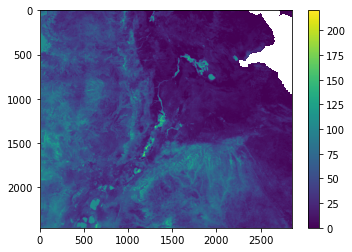

In [4]:
Array = Subdataset.ReadAsArray().astype(np.float32) #lire le sous-ensemble de données en tant que tableau numpy
Array[Array == NDV] = np.nan #remplacer la valeur No Data par la valeur NAN

plt.imshow(Array) #tracer le tableau en tant qu'image
plt.colorbar()
plt.show()

Une fois ouvert en tant que tableau numpy, le jeu de données raster peut être utilisé dans le calcul raster en appliquant des opérations mathématiques telles que l'addition (+), la soustraction (-), la multiplication (*) et la division (/). Par exemple, le code ci-dessous calcule NewArray en divisant le tableau par 30 (nombre moyen de jours par mois). Le NewArray est alors l'AETI journalière moyenne  (mm / jour).

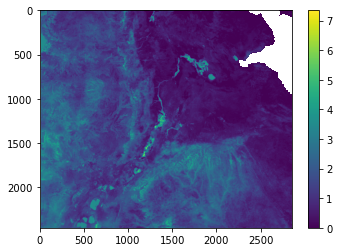

In [5]:
NewArray=Array/30
plt.imshow(NewArray)
plt.colorbar()
plt.show()

Nous pouvons enregistrer ce NewArray en tant que nouveau fichier raster. Pour enregistrer notre résultat sous forme de fichier raster (GeoTIFF), nous devons connaître les propriétés du fichier raster d'origine (driver, valeur Nodata, taille, étendue, projection). Voici l'exemple pour enregistrer le tableau ci-dessus en tant que nouveau fichier raster. Tout d'abord, le nom du fichier de sortie est défini et le dossier de sortie est créé s'il n'existe pas.

In [6]:
output_folder=r'.\data\daily_average_L1_AETI_M'
if not os.path.exists(output_folder): #vérifier si le dossier de sortie output_folder existe
    os.makedirs(output_folder) # sinon créér  output_folder
filename=os.path.basename(in_fh) #obtenir le nom du fichier d'entrée
out_fh=os.path.join(output_folder,filename) #le chemin du fichier de sortie est défini
print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif


Ensuite, la valeur *NewArray* est enregistrée sous *out_fh* dans le [output folder](data/daily_average_L1_AETI_M) en utilisant le code ci-dessous.

In [7]:
datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32']) #créér données du driver
DataSet.GetRasterBand(1).SetNoDataValue(NDV) #définir la valeur Nodata du nouvel ensemble de données
DataSet.SetGeoTransform(GeoT) #Définir la Géotransformation
DataSet.SetProjection(Projection.ExportToWkt()) 
DataSet.GetRasterBand(1).WriteArray(NewArray) #écrire les valeurs correctes du tableau dans la nouvelle base de données
print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif


### Exercice 1
Vous pouvez créer vos propres fonctions pour lire les métadonnées, ouvrir le fichier raster en tant que tableau et écrire le tableau en tant que fichier raster. 
Une fonction en Python est définie par la méthode *def*

**def** Function(Inputs):

    Faites quelque chose avec les entrées
    
    return Sortie
    
**Astuce**: utilisez les exemples de scripts dans les exemples.

In [8]:
import glob
import os
from osgeo import gdal
import numpy as np
import osr

def GetGeoInfo(fh, subdataset = 0):
    '''
    Extraire des metadonnées de GeoTIFF, HDF4 or netCDF file.
    ''' 
    '''
    Ecrivez votre code ici
    ''' 
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    '''
    Lire GeoTIFF ou HDF4 file comme un tableau numpy.
    ''' 
    '''
    Ecrivez votre code ici
    ''' 
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, 
                  Projection, explicit = True, compress = None):      
    '''
    Sauvegarder un tableau numpy comme un fichier raster GeoTIFF.
    ''' 
    '''
    Ecrivez votre code ici
    ''' 

Après avoir terminé et défini les fonctions ci-dessus, vous pouvez les réutiliser dans le code ci-dessous pour calculer les fichiers raster AETI journaliers moyens  à partir de tous les fichiers raster dans le dossier AETI mensuel. Pour appliquer les mêmes fonctions à tous les fichiers raster, nous utilisons une boucle for-loop.

**for** in_fh **in** input_fhs:

    fonctions
    
Cela signifie que le script va parcourir tous les chemins de fichiers dans **input_fhs**, qui est la liste des chemins de fichiers GeoTIFF dans le dossier d'entrée. À chaque itération, le fichier raster sera ouvert en tant que tableau, utilisé pour calculer un nouveau tableau, et le nouveau tableau sera enregistré en tant que nouveau fichier raster dans le dossier de sortie.

In [9]:
### Obtenir les rasters d´entrée
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M' #dossier d'entrée
input_fhs=sorted(glob.glob(input_folder+'\*.tif')) #obtenir la liste des fichiers .tif dans input_folder
output_folder=r'.\data\daily_average_L1_AETI_M' # dossier de sortie output folder
if not os.path.exists(output_folder): #créér output_folder si cela n´existe pas
    os.makedirs(output_folder)
    
### Obtenir GeoInfo
in_fh=input_fhs[0]
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(in_fh)

### Calcul
for in_fh in input_fhs:  
    ### Divisez les données raster par 30
    Array=OpenAsArray(in_fh,nan_values=True)
    NewArray=Array/30
    ### Enregistrer une nouvelle matrice
    filename=os.path.basename(in_fh)
    out_fh=os.path.join(output_folder,filename)
    CreateGeoTiff(out_fh, NewArray, driver, NDV, xsize, ysize, GeoT, Projection)
    print(out_fh)

.\data\daily_average_L1_AETI_M\L1_AETI_0901M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0902M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0903M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0904M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0905M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0906M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0907M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0908M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0909M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0910M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0911M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_0912M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1001M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1002M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1003M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1004M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1005M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1006M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1007M.tif
.\data\daily_average_L1_AETI_M\L1_AETI_1008M.tif
.\data\daily_average

## 2. Agréger les données selon une période

Agréger des données dans une période consiste à combiner tous les fichiers raster dans une période pour calculer de nouvelles données raster. Par exemple, nous additionnons les valeurs de pixel de tous les jeux de données raster AETI d'une saison pour calculer l'AETI saisonnier total. Dans l'exercice du précédent 
[notebook](1_Bulk_download_WaPOR_data.ipynb), vous avez téléchargé les données pour 2 ans 2009 et 2010. Dans cet exemple, nous allons calculer l'AETI total pour la saison juin 2009 à juin 2010.

Tout d'abord, nous obtiendrons la liste des fichiers raster disponibles dans le dossier mensuel AETI.

In [10]:
input_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M'
input_fhs=sorted(glob.glob(input_folder+'\*.tif'))
input_fhs

['.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0901M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0902M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0903M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0904M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0905M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0906M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0907M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0908M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0909M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0910M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0911M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0912M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1001M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1002M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1003M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1004M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1005M.tif

Ensuite, nous utiliserons la fonction WaPOR.API.getAvailData pour lister tous les ID raster disponibles dans la période de juin 2009 à juin 2010

In [11]:
start='2009-06-01'
end='2010-06-30'
time_range=f'{start},{end}'
cube_code='L1_AETI_M'
df_avail=WaPOR.API.getAvailData(cube_code, time_range)
df_avail

,MONTH,raster_id,bbox,time_code
0,2009-06,L1_AETI_0906M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-06-01,2009-07-01)"
1,2009-07,L1_AETI_0907M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-07-01,2009-08-01)"
2,2009-08,L1_AETI_0908M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-08-01,2009-09-01)"
3,2009-09,L1_AETI_0909M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-09-01,2009-10-01)"
4,2009-10,L1_AETI_0910M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-10-01,2009-11-01)"
5,2009-11,L1_AETI_0911M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-11-01,2009-12-01)"
6,2009-12,L1_AETI_0912M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2009-12-01,2010-01-01)"
7,2010-01,L1_AETI_1001M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2010-01-01,2010-02-01)"
8,2010-02,L1_AETI_1002M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2010-02-01,2010-03-01)"
9,2010-03,L1_AETI_1003M,"[{'srid': 'EPSG:4326', 'value': [-30.0044643, ...","[2010-03-01,2010-04-01)"


L'ID du raster est également utilisé comme nom de fichier raster, nous pouvons donc utiliser cette liste pour sélectionner uniquement les fichiers appartenant à cette période. Parcourez la liste des rasters dans le dossier et vérifiez si raster_id dans le nom de fichier raster appartient à la liste des raster_id entre 
6/2009 et 6/2010. Si tel est le cas, le chemin du fichier sera ajouté à la liste de tous les fichiers de la période.

In [12]:
period_fhs=[]
for in_fh in input_fhs:
    # obtenir l'ID du raster à partir du nom du fichier
    raster_id=os.path.basename(in_fh).split('.tif')[0] # obtenir le nom de fichier dans le chemin et exclure l'extension '.tif'
    # vérifier si le raster appartient à la période
    if raster_id in list(df_avail.raster_id): # si raster_id est dans la liste
        period_fhs.append(in_fh) # ajouter le chemin du fichier à period_fhs
period_fhs

['.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0906M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0907M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0908M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0909M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0910M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0911M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_0912M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1001M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1002M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1003M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1004M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1005M.tif',
 '.\\data\\WAPOR.v2_monthly_L1_AETI_M\\L1_AETI_1006M.tif']

Maintenant, nous pouvons parcourir cette liste de tous les fichiers raster de cette période et additionner toutes leurs valeurs de pixels pour calculer l'AETI total de la période.

In [13]:
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(period_fhs[0])
SumArray=np.zeros((ysize,xsize)) #créer un tableau nul et de même taille avec des rasters en entrée 
for fh in period_fhs: #itérer sur tous les fichiers raster de la période
    Array=OpenAsArray(fh,nan_values=True)
    SumArray+=Array
out_fh=os.path.join(f'.\data\L1_AETI_{start}_{end}.tif')
CreateGeoTiff(out_fh, SumArray, driver, NDV, xsize, ysize, GeoT, Projection)

Le raster obtenu peut être tracé comme ci-dessous

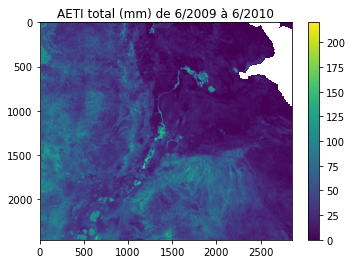

In [14]:
Array=OpenAsArray(out_fh,nan_values=True)
plt.imshow(Array)
plt.colorbar()
plt.title('AETI total (mm) de 6/2009 à 6/2010')
plt.show()

## 3. Transformer des données raster
Les données spatiales sont disponibles en différentes tailles, résolutions et systèmes de référencement spatial. Par exemple, lorsqu'elles sont ouvertes en tant que tableau, la taille des cartes Précipitation et AETI est différente. Ci-dessous la taille du raster Precipitaion.

(2461, 2851)


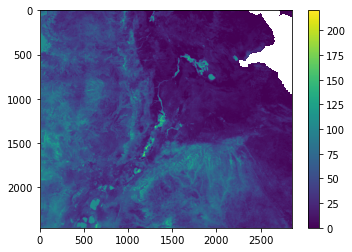

In [15]:
P_fh=r".\data\WAPOR.v2_monthly_L1_PCP_M\L1_PCP_0901M.tif"
P=OpenAsArray(P_fh,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

Et sous cette cellule se trouve la taille du raster AETI

(2461, 2851)


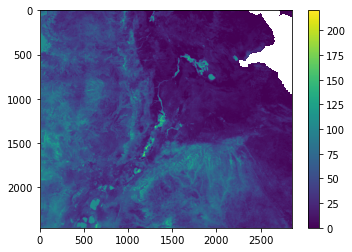

In [16]:
ET_fh=r".\data\WAPOR.v2_monthly_L1_AETI_M\L1_AETI_0901M.tif"
ET=OpenAsArray(ET_fh,nan_values=True)
print(ET.shape)
plt.imshow(ET)
plt.colorbar()
plt.show()

Comme nous pouvons le voir, les données de précipitations ont une résolution inférieure (0,5 degré), donc une taille de tableau plus petite (111x128) que les données AETI (250m et 2461x2851). Pour utiliser ces deux rasters pour un calcul, ils doivent être convertis à la même taille, résolution et projection. Ici, nous utilisons la carte d'utilisation des terres comme modèle pour ramener ces données dans la même forme.

Cela peut être fait en utilisant la fonction gdal.Warp, une fonction de mosaïquage, de reprojection et de déformation d'image. Le gdal.Warp est utilisé pour déformer les données raster données à une taille de données et une étendue spatiale prédéfinies, les reprojeter vers un système de référence spatiale prédéfini. Pour utiliser gdal.Warp et faire correspondre la projection, la taille, l'étendue avec un autre fichier raster, les informations du fichier cible doivent d'abord être obtenues. La fonction ci-dessous est d'obtenir la valeur nodata, le système de référence spatiale, la taille des données, l'étendue spatiale d'un fichier raster à l'aide du package gdal.

Par exemple, ici, le fichier raster de la carte AETI est le fichier cible. Nous voulons faire correspondre la projection, la taille, l'étendue du fichier source, qui est Précipitation, avec le fichier cible.

In [17]:
src_info=gdal.Info(gdal.Open(P_fh),format='json')
dst_info=gdal.Info(gdal.Open(ET_fh),format='json')

print('Source info: ',src_info,'\n')

print('Target info: ',dst_info)

Source info:  {'description': '.\\data\\WAPOR.v2_monthly_L1_PCP_M\\L1_PCP_0901M.tif', 'driverShortName': 'GTiff', 'driverLongName': 'GeoTIFF', 'files': ['.\\data\\WAPOR.v2_monthly_L1_PCP_M\\L1_PCP_0901M.tif'], 'size': [128, 111], 'coordinateSystem': {'wkt': 'GEOGCS["WGS 84",\n    DATUM["WGS_1984",\n        SPHEROID["WGS 84",6378137,298.257223563,\n            AUTHORITY["EPSG","7030"]],\n        AUTHORITY["EPSG","6326"]],\n    PRIMEM["Greenwich",0],\n    UNIT["degree",0.0174532925199433],\n    AUTHORITY["EPSG","4326"]]'}, 'geoTransform': [37.45000000000002, 0.05, 0.0, 12.9, 0.0, -0.05], 'metadata': {'': {'AREA_OR_POINT': 'Area'}, 'IMAGE_STRUCTURE': {'INTERLEAVE': 'BAND'}}, 'cornerCoordinates': {'upperLeft': [37.45, 12.9], 'lowerLeft': [37.45, 7.35], 'lowerRight': [43.85, 7.35], 'upperRight': [43.85, 12.9], 'center': [40.65, 10.125]}, 'wgs84Extent': {'type': 'Polygon', 'coordinates': [[[37.45, 12.9], [37.45, 7.35], [43.85, 7.35], [43.85, 12.9], [37.45, 12.9]]]}, 'bands': [{'band': 1, 'bl

Après avoir obtenu la source *src_info* et les informations sur la cible *dst_info*, nous pouvons remplir ces informations dans *gdal.Warp* comme suit. La fonction rééchantillonnera ensuite les valeurs des données raster de précipitations à la même résolution que celle du raster AETI. Si la fonction *gdal.Warp* est exécutée avec succès, elle renverra un objet *osgeo.gdal.Dataset* et le fichier raster en sortie sera enregistré dans le dossier de sortie [output folder](data/L1_PCP_M_warped).

In [18]:
source_file=P_fh
output_folder=r'.\data\L1_PCP_M_warped'
if not os.path.exists(output_folder): #créer un dossier de sortie s'il n'existe pas
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #obtenir le nom du fichier à partir du chemin source_file
output_file=os.path.join(output_folder,filename) #créer un chemin de fichier de sortie

gdal.Warp(output_file,P_fh,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002D91BCB53F0> >

Le fichier raster de précipitation en sortie aura désormais la même taille que le raster AETI.

(2461, 2851)


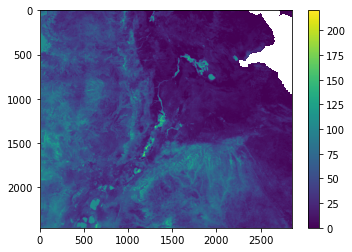

In [19]:
P=OpenAsArray(output_file,nan_values=True)
print(P.shape)
plt.imshow(P)
plt.colorbar()
plt.show()

### Exercice 2
Créez une fonction pour transformer tout fichier raster avec un raster donné.
Utilisez cette fonction pour faire correspondre la projection, la taille, l'étendue de toutes les données de précipitations avec les données ET.

In [20]:
def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    Ramener tous les fichiers raster d'une liste à la même taille, 
    résolution et projection avec un fichier raster source.
    """
    '''
    Ecrivez votre code ici
    '''
    return output_files

In [ ]:
input_folder=r".\data\WAPOR.v2_monthly_L1_PCP_M"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_M_warped'
MatchProjResNDV(ET_fh, input_fhs, output_folder)

## 4. Découper suivant la ligne de coupe d’un shapefile
Lorsque nous devons exclure des pixels en dehors de la région d'intérêt, par exemple, dans le cas d'un bassin hydrologique ou d'un bloc d'irrigation, nous pouvons utiliser *gdal.Warp* avec l'option de ligne de coupe pour découper un raster à la limite du polygone d'un fichier de formes. Les exemples de codes ci-dessous montrent comment procéder avec les cartes raster des précipitations.

Tout d'abord, nous obtenons le chemin d'accès au fichier raster d'entrée et créons un dossier de sortie 
[output folder](data/L1_PCP_M_clipped)

In [21]:
input_fh=r".\data\WAPOR.v2_monthly_L1_PCP_M\L1_PCP_0901M.tif" # chemin d´accès vers le raster à découper 
shp_fh=r".\data\Awash_shapefile.shp" #chemin vers le raster à découper chemin vers le fichier de formes 
#contenant le polygone de la région d'intérêt

output_folder=r'.\data\L1_PCP_M_clipped'#chemin d´accès vers le dossier de sortie output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(source_file) #créer un dossier de sortie s'il n'existe pas
output_fh=os.path.join(output_folder,filename) #créer un chemin de fichier de sortie
print(output_fh)

.\data\L1_PCP_M_clipped\L1_PCP_0901M.tif


Après avoir défini le fichier raster d'entrée et de sortie et les chemins du fichier de formes, nous pouvons utiliser la fonction de bibliothèque ogr pour lire le jeu de données de fichier de formes en tant qu'objet gdal pour obtenir le nom de la couche. Ensuite, utilisez le chemin et la couche du fichier de formes comme arguments d'options pour la fonction gdal.Warp. Vérifiez le fichier de sortie dans le dossier de sortie 
[output folder](data/L1_PCP_M_clipped).

In [22]:
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) #lire le fichier de formes en tant que jeu de données gdal
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)

Vous trouverez ci-dessous la carte du raster en entrée avant le découpage:

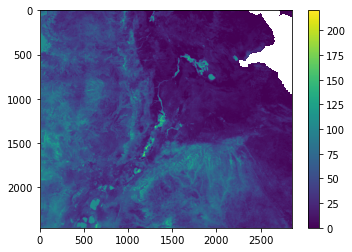

In [23]:
input_array=OpenAsArray(input_fh,nan_values=True)
plt.imshow(input_array)
plt.colorbar()
plt.show()

Et ci-dessous se trouve la carte du raster en sortie après le découpage:

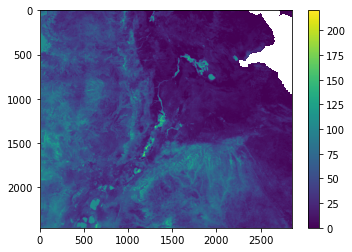

In [24]:
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

Notez que le fichier raster des précipitations d'origine a une résolution spatiale de 5 km. Par conséquent, lorsque le clip à la ligne de coupe est effectué, nous pouvons voir les pixels grossiers sur la limite. Si nous avons besoin que la ligne de coupe soit plus lisse, nous pouvons utiliser le fichier raster des précipitations qui a été déformé à une résolution spatiale plus élevée (250 m) comme fichier d'entrée. Par exemple, voyez la différence entre la carte découpée à partir d'un raster de résolution de 5 km (ci-dessus) et la carte découpée à partir d'un raster de résolution de 250 m (ci-dessous).

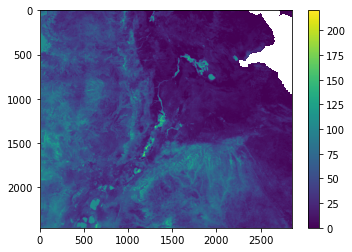

In [25]:
input_fh=r".\data\L1_PCP_M_warped\L1_PCP_0901M.tif"
inDriver = ogr.GetDriverByName("ESRI Shapefile")
inDataSource = inDriver.Open(shp_fh, 1) #lire le fichier de formes en tant que jeu de données gdal
inLayer = inDataSource.GetLayer()    
options = gdal.WarpOptions(cutlineDSName = shp_fh,
                           cutlineLayer = inLayer.GetName(),
                           cropToCutline = True, 
                           dstNodata=NDV
                           )
sourceds = gdal.Warp(output_fh, input_fh, options = options)
output_array=OpenAsArray(output_fh,nan_values=True)
plt.imshow(output_array)
plt.colorbar()
plt.show()

### Exercice 3

Créez une fonction CliptoShp () pour découper toutes les précipitations mensuelles déformées et toutes les données raster mensuelles AETI et LCC annuelles téléchargées à partir de l'exercice précédent [notebook](1_Bulk_download_WaPOR_data.ipynb).

In [26]:
def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """
    Délimiter le raster à la ligne de contour d'un fichier de formes
    
    """
    '''
    Écrivez vos scripts ici
    '''
    return output_fhs

À l'aide de la fonction **CliptoShp** définie, tous les fichiers raster des dossiers d'entrée peuvent être coupés à la limite du polygone du fichier de formes. Les fichiers de sortie seront enregistrés dans les dossiers de sortie.

In [ ]:
input_folder=r".\data\L1_PCP_E_warped"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_PCP_M_clipped'
CliptoShp(input_fhs, output_folder,shp_fh)

input_folder=r".\data\WAPOR.v2_monthly_L1_AETI_M"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_AETI_M_clipped'
if not os.path.exists(output_folder): #créer un dossier de sortie s'il n'existe pas
    os.makedirs(output_folder)
CliptoShp(input_fhs, output_folder,shp_fh)

input_folder=r".\data\WAPOR.v2_yearly_L1_LCC_A"
input_fhs=sorted(glob.glob(os.path.join(input_folder,'*.tif')))
output_folder=r'.\data\L1_LCC_A_clipped'
if not os.path.exists(output_folder): #créer un dossier de sortie s'il n'existe pas
    os.makedirs(output_folder)
CliptoShp(input_fhs, output_folder,shp_fh)